In [24]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, MultiTaskLasso, MultiTaskElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pingouin as pg
import warnings
import hdbscan
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from matplotlib import cm
import plotly.express as px
import plotly.io as pio
from matplotlib.colors import to_hex
pio.renderers.default = 'notebook'  # or 'iframe' or 'vscode' depending on your setup

palette = sns.color_palette('tab10')
palette2 = sns.color_palette('tab20')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Load all the spike and value data

In [2]:
def load_nef_values(load=True):
    if load:
        values = pd.read_pickle("data/nef_values_condensed.pkl")
    else:
        emp = pd.read_pickle("data/empirical.pkl")
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        dfs.append(pd.read_pickle(f'data/nef_spikes/{file}_values.pkl'))
        values = pd.concat(dfs, ignore_index=True)
        # values['dvs'] = np.abs(values['va'] - values['vb'])
        # values['dva'] = np.abs(values['vl'] - values['vr'])
        values['dvs'] = values['va'] - values['vb']
        values['dva'] = values['vl'] - values['vr']
        # values['dvt'] = values['dvs'] + values['dva']
        # values.rename(columns={'wab': 'w'}, inplace=True)
        # values = values.dropna()
        values = values.drop(columns='block_type')
        values = values.drop(columns='before')
        values = values.drop(columns='after')
        # values = values.drop(columns='dvt')
        values = values.drop(columns='acc')
        values.to_pickle("data/nef_values_condensed.pkl")
    return values

In [3]:
def load_rl_values(load=True):
    if load:
        values = pd.read_pickle("data/rl_values_condensed.pkl")
    else:
        dfs = []
        for monkey in ['V', 'W']:
            for session in [0,1,2,3]:
                for block in range(1, 25):
                    for trial in range(1, 81):
                        file = f"monkey{monkey}_session{session}_block{block}_trial{trial}"
                        try:
                            dfs.append(pd.read_pickle(f'data/emp_spikes/{file}_values.pkl'))
                        except:
                            # print(block, trial)
                            pass
        values = pd.concat(dfs, ignore_index=True)
        # values = values.drop(columns='omega_BlockMean')
        # values = values.dropna()
        values.to_pickle("data/rl_values_condensed.pkl")
    return values

In [4]:
def load_nef_spikes(load=True):
    filename = "nef_spikes_condensed_vwa"
    if load:
        with open(f'data/{filename}.pkl', 'rb') as file:
            nef_spikes = pickle.load(file)
    else:
        nef_spikes = {}
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            nef_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                nef_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    nef_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        # v = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['v'].sum(axis=0)  # sum over time
                        # w = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['w'].sum(axis=0)  # sum over time
                        # a = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['a'].sum(axis=0)  # sum over time
                        vwa = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['vwa'].sum(axis=0)  # sum over time
                        # evc = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['evc'].sum(axis=0)  # sum over time
                        # ewt = np.load(f"data/nef_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_spikes.npz")['ewt'].sum(axis=0)  # sum over time
                        combined = np.concatenate([vwa], axis=0)
                        # combined = np.concatenate([v,w,a,vwa,evc,ewt], axis=0)
                        nef_spikes[monkey][session][block][trial] = combined
        with open(f'data/{filename}.pkl', 'wb') as f:
            pickle.dump(nef_spikes, f)
    return nef_spikes

In [5]:
def load_monkey_spikes(load=True, reward_spikes=False):
    if load:
        with open('data/monkey_spikes_condensed.pkl', 'rb') as file:
            emp_spikes = pickle.load(file)
    else:
        emp_spikes = {}
        name = "spikes" if not reward_spikes else "spikes_reward"
        emp = pd.read_pickle("data/empirical.pkl")
        for monkey in emp['monkey'].unique():
            emp_spikes[monkey] = {}
            for session in emp['session'].unique():
                session = int(session)
                emp_spikes[monkey][session] = {}
                for block in emp.query("monkey==@monkey & session==@session")['block'].unique():
                    block = int(block)
                    emp_spikes[monkey][session][block] = {}
                    for trial in emp.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        trial=int(trial)
                        try:
                            file = f"data/emp_spikes/monkey{monkey}_session{session}_block{block}_trial{trial}_{name}.npz"
                            emp_spikes[monkey][session][block][trial] = np.load(file)['spikes']
                        except:
                            print(monkey, session, block, trial)
                            # pass
        with open('data/monkey_spikes_condensed.pkl', 'wb') as f:
            pickle.dump(emp_spikes, f)
    return emp_spikes

In [6]:
def regress_spikes_values(spikes, values, variables, spike_type, load=True, model_type='lassocv', preprocess="standard",
                          alpha=0.01, n_folds=10, n_pca=20, max_iter=1000):
    dfs_error = []
    dfs_weight = []
    columns_error = ['monkey', 'session', 'fold', 'variable', 'r2']
    columns_weight = ['monkey', 'session', 'fold', 'neuron', 'population', 'variable', 'weight']

    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            
            # Build X (spikes) and Y (variable) arrays
            if load:
                X = np.load(f"data/spikes/monkey{monkey}_session{session}_{spike_type}.npz")['X']
                Y = np.load(f"data/spikes/monkey{monkey}_session{session}_{spike_type}.npz")['Y']
            else:
                print("collecting spikes for", monkey, session)
                X = []
                Y = []
                for block in values.query("monkey==@monkey & session==@session")['block'].unique():
                    for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
                        try:
                            X.append(spikes[monkey][session][block][trial])
                            y = []
                            for variable in variables:
                                y.append(values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variable].to_numpy()[0])
                            Y.append(y)
                        except:
                            pass
                X, Y = np.array(X), np.array(Y)
                np.savez_compressed(f"data/spikes/monkey{monkey}_session{session}_{spike_type}.npz", X=X, Y=Y)

            # Fit model using nested cross-validation, save the R2 values
            print("fitting model for", monkey, session)
            cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
            i_fold = 0
            for train_idx, test_idx in cv.split(X):
                start = time.time()
                X_train, Y_train = X[train_idx], Y[train_idx]
                X_test, Y_test = X[test_idx], Y[test_idx]
                if model_type == 'lassocv':
                    model_obj = MultiTaskLasso(alpha=alpha, max_iter=max_iter, warm_start=True)
                elif model_type == 'elasticnetcv':
                    model_obj = MultiTaskElasticNet(alpha=alpha, max_iter=max_iter)
                if preprocess == 'standard':
                    model = Pipeline([('scaler', StandardScaler()), ('reg', model_obj)])
                elif preprocess == 'pca':
                    model = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=n_pca)), ('reg', model_obj)])
                    # model = make_pipeline(StandardScaler(), PCA(n_components=n_pca), model_obj)
                else:
                    model = model_obj
                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)
                r2_fold = r2_score(Y_test, Y_pred, multioutput='raw_values')
                Y_pred = model.predict(X_test)
                for v, variable in enumerate(variables):
                    dfs_error.append(pd.DataFrame([[monkey, session, i_fold, variable, r2_fold[v]]], columns=columns_error))
                end = time.time()
                print(f"fold {i_fold}, fitting runtime {(end-start)/60:.3} minutes; R-squared {np.mean(r2_fold)}")

                # Extract weights from fitted model, remove neurons that don't contribute
                if preprocess=='standard':
                    weights = model.named_steps['reg'].coef_.T
                elif preprocess=='pca':
                    pca = model.named_steps['pca']
                    reg = model.named_steps[model.steps[-1][0]]
                    weights = pca.components_.T @ reg.coef_
                else:
                    weights = model.coef_
                sqr_weights = np.square(weights)
                n_neurons = sqr_weights.shape[0]

                # Save the weights
                for v, variable in enumerate(variables):
                    df = pd.DataFrame(columns=columns_weight)
                    df['monkey'] = [monkey for _ in range(n_neurons)]
                    df['session'] = [session for _ in range(n_neurons)]
                    df['fold'] = [i_fold for _ in range(n_neurons)]
                    df['neuron'] = [n for n in range(n_neurons)]
                    if spike_type=='nef':
                        pops = []
                        for pop in ['v', 'w', 'a', 'vwa', 'evc', 'ewt']:
                            pops.extend([pop for _ in range(int(n_neurons/6))])
                        df['population'] = pops
                    if spike_type=='monkey':
                        df['population'] = np.load(f"data/emp_spikes/monkey{monkey}_session{session}_pops.npz")['pops']
                    df['variable'] = [variable for _ in range(n_neurons)]
                    df['weight'] = sqr_weights[:,v]
                    # df['weight'] = filtered_weights[:,v]
                    dfs_weight.append(df)
                i_fold += 1
    df_error = pd.concat(dfs_error, ignore_index=True)
    df_weight = pd.concat(dfs_weight, ignore_index=True)
    return df_error, df_weight

In [7]:
nef_values = load_nef_values(load=False)
rl_values = load_rl_values(load=False)

In [8]:
nef_spikes = load_nef_spikes(load=False)
# monkey_spikes = load_monkey_spikes(load=False)
# monkey_spikes_reward = load_monkey_spikes(load=False, reward_spikes=True)

In [2]:
# variables = ['va', 'vb', 'vl', 'vr', 'al', 'ar', 'dvs', 'dva', 'w', 'cloc', 'rew']
# nef_error, nef_weight = regress_spikes_values(nef_spikes, nef_values, variables, "nef",
#                                               load=False, alpha=0.01, max_iter=3000, n_folds=5)
# nef_error.to_pickle("data/nef_error_vwa.pkl")
# nef_weight.to_pickle("data/nef_weight_vwa.pkl")
nef_error = pd.read_pickle("data/nef_error_vwa.pkl")
nef_weight = pd.read_pickle("data/nef_weight_vwa.pkl")

In [3]:
# variables = ['chosen location','V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'DV_left', 'DV_right', 'DeltaV_Stim', 'DeltaV_Act', 'omega']
# monkey_error1, monkey_weight1 = regress_spikes_values(monkey_spikes, rl_values, variables, "monkey",
#                                                     load=False, alpha=0.01, max_iter=3000, n_folds=5)
# variables2 = ['reward']
# monkey_error2, monkey_weight2 = regress_spikes_values(monkey_spikes_reward, rl_values, variables2, "monkey",
#                                                     load=False, alpha=0.01, max_iter=3000, n_folds=5)
# monkey_error1.to_pickle("data/monkey_error1.pkl")
# monkey_weight1.to_pickle("data/monkey_weight1.pkl")
# monkey_error2.to_pickle("data/monkey_error2.pkl")
# monkey_weight2.to_pickle("data/monkey_weight2.pkl")

# monkey_error = pd.concat([monkey_error1, monkey_error2], ignore_index=True)
# monkey_weight = pd.concat([monkey_weight1, monkey_weight2], ignore_index=True)
# monkey_error.to_pickle("data/monkey_error.pkl")
# monkey_weight.to_pickle("data/monkey_weight.pkl")

monkey_error = pd.read_pickle("data/monkey_error.pkl")
monkey_weight = pd.read_pickle("data/monkey_weight.pkl")

# 1. Predict (RL/NEF) values using (Monkey/Model) spikes with linear regression

/tmp/ipykernel_3568720/2845036959.py:2: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(nef_error, x='variable', y='r2', hue='variable', ax=axes, palette=palette)


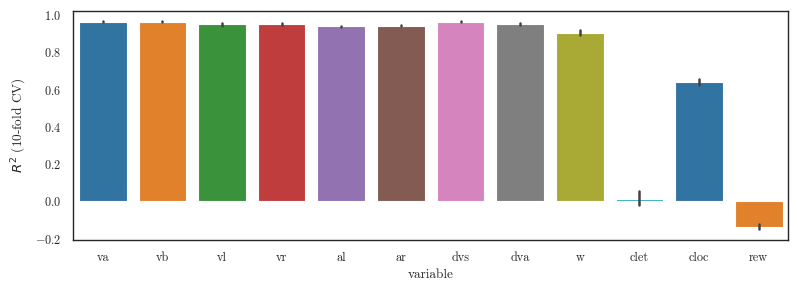

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=True, sharex=True)
sns.barplot(nef_error, x='variable', y='r2', hue='variable', ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel=r"$R^2$"+" (10-fold CV)")
fig.savefig("plots/nef_spikes_nef_values_regression.jpg", dpi=600)

### Figure 1.1
Linear regression on the model spikes can recreate the "ground truth" values for the NEF model almost perfectly. This isn't surprising, since these "ground truth" values are obtained using another linear decoding method (based on the NEF) from the model spikes

/tmp/ipykernel_3399480/1189144867.py:3: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(monkey_error, x='variable', y='r2', hue='variable', order=vs, hue_order=vs, ax=axes, palette=palette)


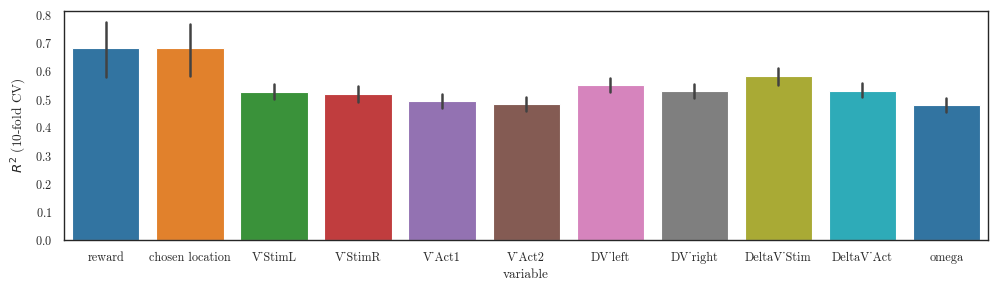

In [21]:
vs = ['chosen location','V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'DV_left', 'DV_right', 'DeltaV_Stim', 'DeltaV_Act', 'omega', 'reward']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
sns.barplot(monkey_error, x='variable', y='r2', hue='variable', order=vs, hue_order=vs, ax=axes, palette=palette)
fig.tight_layout()
axes.set(ylabel=r"$R^2$"+" (10-fold CV)")
fig.savefig("plots/monkey_spikes_rl_values_regression.jpg", dpi=600)

### Figure 1.2

Linear regression on the monkey spikes can recreate the "ground truth" values from the RL model fairly well. Note that basic Linear or Ridge regression achieves lower R-squared.

# 2. Inspect regression coefficients from each neural population

In [4]:
# remove neurons where all weights are zero
def remove_bad_neurons(df):
    # Step 1: Group by monkey, session, fold, neuron
    group_cols = ['monkey', 'session', 'fold', 'neuron']
    grouped = df.groupby(group_cols)
    # Step 2: Identify neuron groups where all weights are 0
    all_zero_mask = grouped['weight'].transform(lambda w: (w != 0).any())
    # Step 3: Keep only rows where at least one weight is non-zero within the neuron group
    cleaned_df = df[all_zero_mask].copy()
    print(f"kept {100*cleaned_df.size / df.size}% of neurons")
    return cleaned_df

kept 29.823333333333334% of neurons


/tmp/ipykernel_3575664/120928348.py:3: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(cleaned_nef_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette)


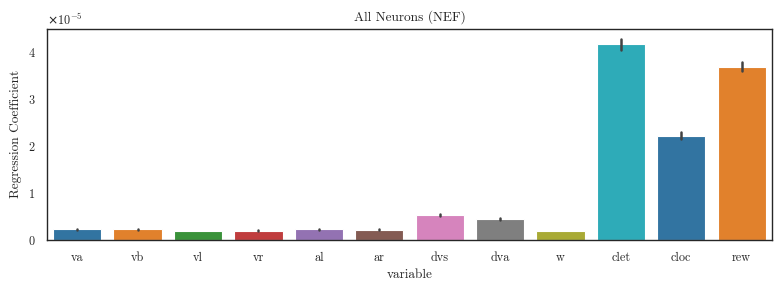

In [5]:
cleaned_nef_weights = remove_bad_neurons(nef_weight)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
sns.barplot(cleaned_nef_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette)
axes.set(title="All Neurons (NEF)", ylabel='Regression Coefficient')
fig.tight_layout()
fig.savefig("plots/nef_regression_weights_all.jpg", dpi=600)

/tmp/ipykernel_3399480/1419195142.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(cleaned_nef_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
/tmp/ipykernel_3399480/1419195142.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(cleaned_nef_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
/tmp/ipykernel_3399480/1419195142.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(cleaned_nef_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
/tmp/ipykernel_3399480/1419195142.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(cleaned_nef_weights.query("po

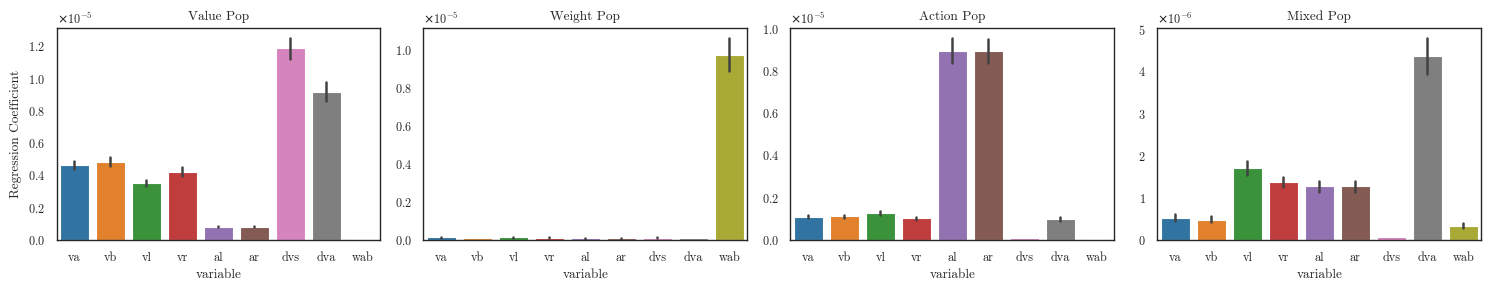

In [111]:
# cleaned_nef_weights = remove_bad_neurons(nef_weight)
populations = cleaned_nef_weights['population'].unique()[:-2]
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(15, 3), sharey=False)
for p, population in enumerate(populations):
    sns.barplot(cleaned_nef_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
    axes[p].set(title=population)
axes[0].set(title="Value Pop", ylabel='Regression Coefficient')
axes[1].set(title="Weight Pop", ylabel=None)
axes[2].set(title="Action Pop", ylabel=None)
axes[3].set(title="Mixed Pop", ylabel=None)
# axes[4].set(title="Value Error Pop", ylabel=None)
# axes[5].set(title="Weight Error Pop", ylabel=None)
fig.tight_layout()
fig.savefig("plots/nef_regression_weights_pop.jpg", dpi=600)

### Figure 2.1
Clusters for different variable groups are clearly visible in the different NEF populations

kept 91.08936725375082% of neurons


/tmp/ipykernel_3575664/2325627342.py:4: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(cleaned_monkey_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette, order=vs, hue_order=vs)


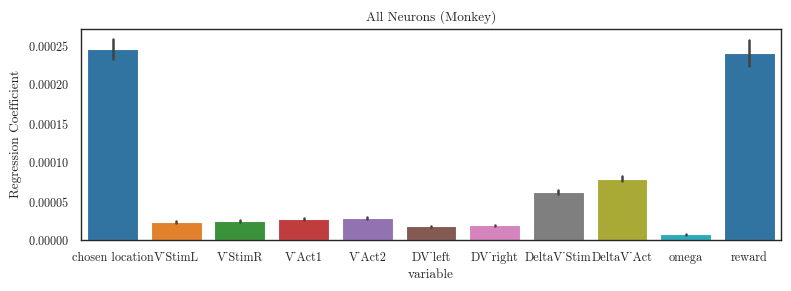

In [6]:
vs = ['chosen location','V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'DV_left', 'DV_right', 'DeltaV_Stim', 'DeltaV_Act', 'omega', 'reward']
cleaned_monkey_weights = remove_bad_neurons(monkey_weight)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
sns.barplot(cleaned_monkey_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette, order=vs, hue_order=vs)
axes.set(title="All Neurons (Monkey)", ylabel='Regression Coefficient')
fig.tight_layout()
fig.savefig("plots/monkey_regression_weights_all.jpg", dpi=600)

kept 91.08936725375082% of neurons


/tmp/ipykernel_3399480/2959560468.py:5: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(cleaned_monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight',
/tmp/ipykernel_3399480/2959560468.py:5: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(cleaned_monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight',
/tmp/ipykernel_3399480/2959560468.py:5: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(cleaned_monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight',
/tmp/ipykernel_3399480/2959560468.py:5: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninter

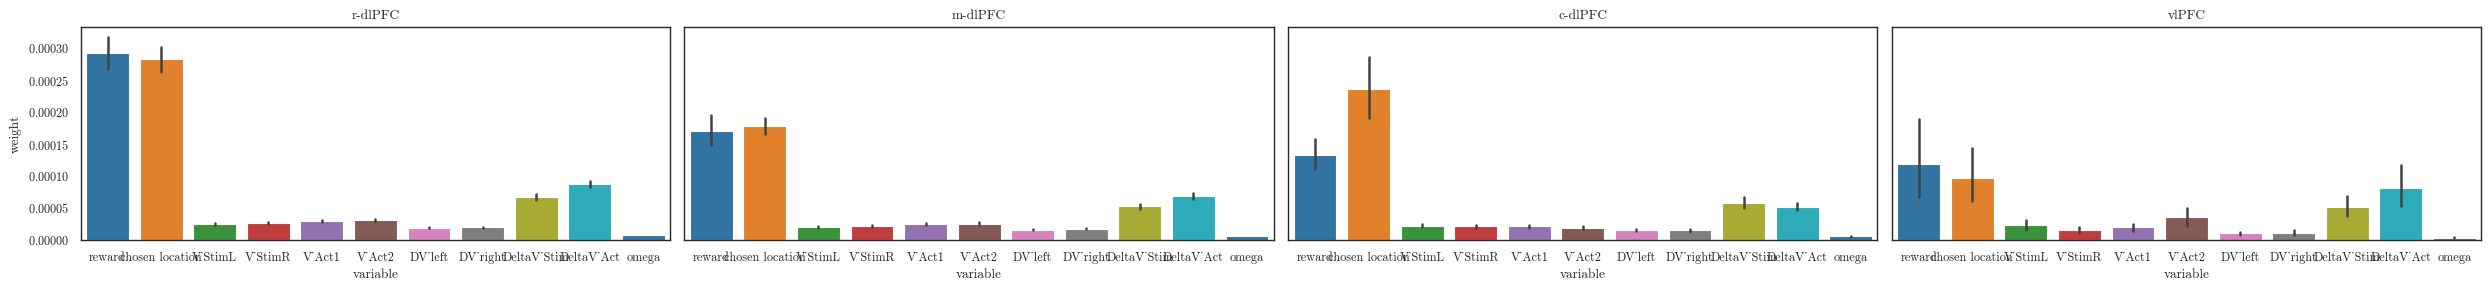

In [25]:
cleaned_monkey_weights = remove_bad_neurons(monkey_weight)
populations = cleaned_monkey_weights['population'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(25, 3), sharey=True)
for p, population in enumerate(populations):
    sns.barplot(cleaned_monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight',
                ax=axes[p], palette=palette, order=vs, hue_order=vs)
    axes[p].set(title=population)
fig.tight_layout()
fig.savefig("plots/monkey_regression_weights_pop.jpg", dpi=600)

### Figure 2.2
Different anatomical regions of dlPFC/vPFC don't seem to represent different variables

In [381]:
def clean_xy(x, y):
    x = np.array(x) # shape: (n_trials, n_neurons)
    y = np.array(y) # shape: (n_trials, n_values)
    if y.shape[1] > 1:
        row_std = np.std(y, axis=1)
        keep = row_std > 1e-6
        x = x[keep, :]  # Remove rows with low variance
        y = y[keep, :]  # Remove rows with low variance
    return x, y

def flatten_rdm(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

def RSA(monkey, session, spikes, values, variables,
        spike_type='all', preprocess=True, metric='correlation', temporal_auto='partial_out'):
    X_spikes = []
    Y_values = []
    for block in values.query("monkey==@monkey & session==@session")['block'].unique():
        for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
            try:
                x = spikes[monkey][session][block][trial].astype(float)
                y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variables].values.flatten()
                n_neurons = int(x.shape[0]/6)
                if spike_type=='all':
                    X_spikes.append(x)
                elif spike_type=='value':
                    X_spikes.append(x[0:n_neurons])
                elif spike_type=='weight':
                    X_spikes.append(x[n_neurons:2*n_neurons])
                elif spike_type=='action':
                    X_spikes.append(x[2*n_neurons:3*n_neurons])
                elif spike_type=='mixed':
                    X_spikes.append(x[3*n_neurons:4*n_neurons])
                elif spike_type=='evc':
                    X_spikes.append(x[4*n_neurons:5*n_neurons])
                elif spike_type=='ewt':
                    X_spikes.append(x[5*n_neurons:6*n_neurons])
                Y_values.append(y.astype(float))
            except:
                # print(f"skipping {monkey} {session} {block} {trial}")
                pass
    X_spikes, Y_values = clean_xy(X_spikes, Y_values)
    if preprocess:
        X_spikes = StandardScaler().fit_transform(X_spikes)
    X_rdm = squareform(pdist(X_spikes, metric=metric))  # shape: (n_trials, n_trials)
    Y_rdm = squareform(pdist(Y_values, metric=metric))  # shape: (n_trials, n_trials)
    X_vec = flatten_rdm(X_rdm)
    Y_vec = flatten_rdm(Y_rdm)
    if temporal_auto=='partial_out':
        trial_indices = np.arange(X_rdm.shape[0]).reshape(-1, 1)
        time_rdm = squareform(pdist(trial_indices, metric=metric))
        time_vec = flatten_rdm(time_rdm)
        df = pd.DataFrame({'X': X_vec, 'Y': Y_vec, 'Z': time_vec})
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            result = pg.partial_corr(data=df, x='X', y='Y', covar='Z', method='spearman')
        rsa_score, pval = result['r'].to_numpy()[0], result['p-val'].to_numpy()[0]
    else:
        rsa_score, pval = spearmanr(X_vec, Y_vec)  # Spearman correlation
    return np.square(rsa_score), pval

def RSA_vs_variables(spikes, values, variables_list, spike_type,
                     preprocess=True, metric='correlation', temporal_auto=None):
    dfs = []
    columns = ['monkey', 'session', 'variables', 'score', 'p']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            for variables in variables_list:
                score, p = RSA(monkey, session, spikes, values, variables,
                               spike_type, preprocess, metric, temporal_auto)
                dfs.append(pd.DataFrame([[monkey, session, variables, score, p]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


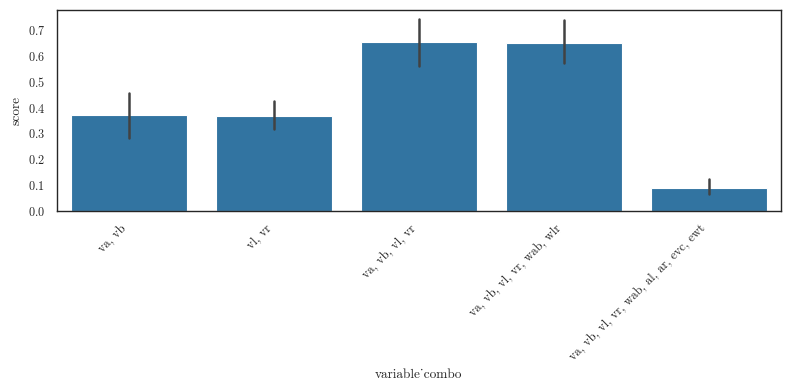

In [374]:
a = ['va', 'vb']
b = ['vl', 'vr']
c = ['va', 'vb', 'vl', 'vr']
d = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr',]
e = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
variables_list = [a,b,c,d,e]
nef_rsa = RSA_vs_variables(nef_spikes, nef_values, variables_list,
                           spike_type='value', preprocess=True, metric='cosine', temporal_auto=None)

nef_rsa['variable_combo'] = nef_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(nef_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
# fig.savefig("plots/NEF_RSA.jpg", dpi=600)

### Figure 2.1
There is a moderate correlation between model spike variance and model variables. Including more variables significantly improves the correlation. However, the correlation with RSA is far less strong than the $R^2$ analysis in Fig 1. Even when looking only at the spikes from a single NEF population, $R^2$ for the associated variables is far less than $1$. This suggests to me that there are limits to how much we can infer about representations with this method, even when we know (through NEF modeling and other anslyses) that the representations are a certain way.

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


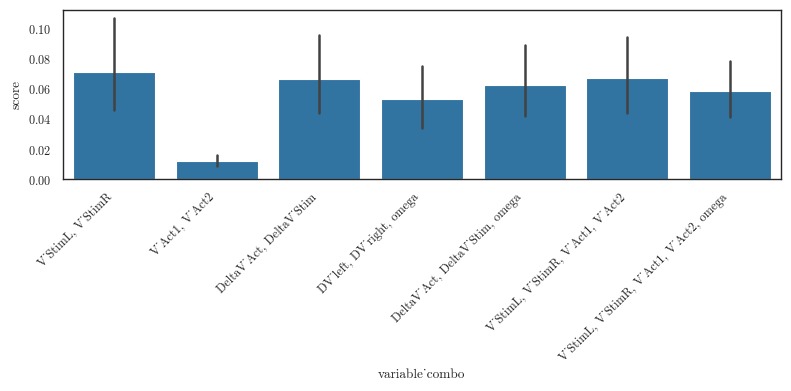

In [389]:
a = ['V_StimL', 'V_StimR']
b = ['V_Act1', 'V_Act2']
c = ['V_Act1', 'V_Act2']
d = ['DeltaV_Act', 'DeltaV_Stim']
e = ['DV_left', 'DV_right', 'omega']
f = ['DeltaV_Act', 'DeltaV_Stim', 'omega']
g = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2']
h = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'omega']
variables_list = [a,b,c,d,e,f,g,h]
monkey_rsa = RSA_vs_variables(monkey_spikes, rl_values, variables_list,
                              spike_type='all', preprocess=True, metric='cosine')

monkey_rsa['variable_combo'] = monkey_rsa['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(monkey_rsa, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
fig.savefig("plots/monkey_spikes_RSA.jpg", dpi=600)

### Figure 2.2
There seems to be a weak correlation between the trial-to-trial variance in the monkey spike data, and the trial-to-trial variance in the variables from the RL model.

In [401]:
def clean_xy(x, y):
    x = np.array(x) # shape: (n_trials, n_neurons)
    y = np.array(y) # shape: (n_trials, n_values)
    if y.shape[1] > 1:
        row_std = np.std(y, axis=1)
        keep = row_std > 1e-6
        x = x[keep, :]  # Remove rows with low variance
        y = y[keep, :]  # Remove rows with low variance
    return x, y

def flatten_rdm(rdm):
    return rdm[np.triu_indices_from(rdm, k=1)]

def RDM_GLM(monkey, session, spikes, values, variables,
        spike_type='all', preprocess=True, metric='correlation', model_type='lassocv', n_folds=10):
    X_spikes = []
    Y_values = []
    for block in values.query("monkey==@monkey & session==@session")['block'].unique():
        for trial in values.query("monkey==@monkey & session==@session & block==@block")['trial'].unique():
            try:
                x = spikes[monkey][session][block][trial].astype(float)
                y = values.query("monkey==@monkey & session==@session & block==@block & trial==@trial")[variables].values.flatten()
                n_neurons = int(x.shape[0]/6)
                if spike_type=='all':
                    X_spikes.append(x)
                elif spike_type=='value':
                    X_spikes.append(x[0:n_neurons])
                elif spike_type=='weight':
                    X_spikes.append(x[n_neurons:2*n_neurons])
                elif spike_type=='action':
                    X_spikes.append(x[2*n_neurons:3*n_neurons])
                elif spike_type=='mixed':
                    X_spikes.append(x[3*n_neurons:4*n_neurons])
                elif spike_type=='evc':
                    X_spikes.append(x[4*n_neurons:5*n_neurons])
                elif spike_type=='ewt':
                    X_spikes.append(x[5*n_neurons:6*n_neurons])
                Y_values.append(y.astype(float))
            except:
                # print(f"skipping {monkey} {session} {block} {trial}")
                pass
    X_spikes, Y_values = clean_xy(X_spikes, Y_values)
    if preprocess:
        X_spikes = StandardScaler().fit_transform(X_spikes)
    X_rdm = squareform(pdist(X_spikes, metric=metric))  # shape: (n_trials, n_trials)
    Y_rdm = squareform(pdist(Y_values, metric=metric))  # shape: (n_trials, n_trials)
    X_vec = flatten_rdm(X_rdm).reshape(-1, 1)
    Y_vec = flatten_rdm(Y_rdm)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    preds = np.zeros_like(Y_vec)
    for train_idx, test_idx in kf.split(X_vec):
        if model_type == 'linear':
            model = LinearRegression()
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha)
        elif model_type == 'ridgecv':
            model = RidgeCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
        elif model_type == 'lassocv':
            model = LassoCV(alphas=np.logspace(-3, 1, 10), cv=n_folds, max_iter=10000)
            # model = MultiOutputRegressor(LassoCV(alphas=np.logspace(-2, 1, 10), cv=n_folds, max_iter=10000))
            # model = MultiTaskLassoCV(alphas=np.logspace(-2, 1, 10), cv=n_folds, max_iter=5000, n_jobs=-1)
        elif model_type == 'elasticnetcv':
            model = ElasticNetCV(l1_ratio=[.1, .5, .9, 1.0], alphas=np.logspace(-3, 1, 10), cv=n_folds)
            # model = MultiTaskElasticNetCV(alphas=np.logspace(-2, 1, 10), l1_ratio=0.5, cv=n_folds, n_jobs=-1)
        model.fit(X_vec[train_idx], Y_vec[train_idx])
        preds[test_idx] = model.predict(X_vec[test_idx])
    r2 = r2_score(Y_vec, preds)
    return r2

def RDM_GLM_vs_variables(spikes, values, variables_list, spike_type,
                     preprocess=True, metric='correlation'):
    dfs = []
    columns = ['monkey', 'session', 'variables', 'score']
    for monkey in ['V', 'W']:
        for session in [0,1,2,3]:
            print(monkey, session)
            for variables in variables_list:
                score = RDM_GLM(monkey, session, spikes, values, variables,
                               spike_type, preprocess, metric)
                dfs.append(pd.DataFrame([[monkey, session, variables, score]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return data

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


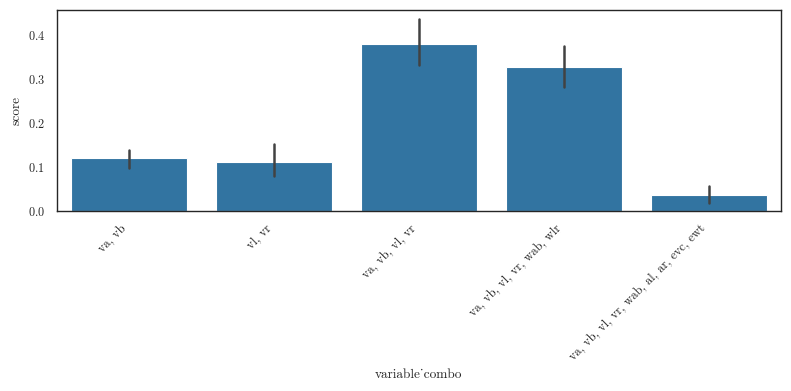

In [402]:
a = ['va', 'vb']
b = ['vl', 'vr']
c = ['va', 'vb', 'vl', 'vr']
d = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr',]
e = ['va', 'vb', 'vl', 'vr', 'wab', 'al', 'ar', 'evc', 'ewt']
variables_list = [a,b,c,d,e]
nef_rdm_glm = RDM_GLM_vs_variables(nef_spikes, nef_values, variables_list, spike_type='value')

nef_rdm_glm['variable_combo'] = nef_rdm_glm['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(nef_rdm_glm, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
# fig.savefig("plots/NEF_RSA.jpg", dpi=600)

V 0
V 1
V 2
V 3
W 0
W 1
W 2
W 3


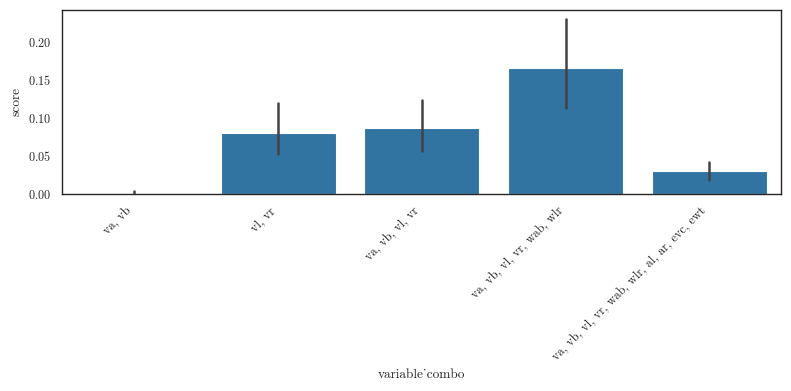

In [403]:
a = ['va', 'vb']
b = ['vl', 'vr']
c = ['va', 'vb', 'vl', 'vr']
d = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr',]
e = ['va', 'vb', 'vl', 'vr', 'wab', 'wlr', 'al', 'ar', 'evc', 'ewt']
variables_list = [a,b,c,d,e]
nef_rdm_glm = RDM_GLM_vs_variables(nef_spikes, nef_values, variables_list, spike_type='mixed')

nef_rdm_glm['variable_combo'] = nef_rdm_glm['variables'].apply(lambda x: ', '.join(x))
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(nef_rdm_glm, x='variable_combo', y='score', ax=ax, color=palette[0])
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
# fig.savefig("plots/NEF_RSA.jpg", dpi=600)

### Figure 2B
When I use a GLM to decode the RDM for the NEF variables from the RDM for the NEF spikes, the resuling $R^2$ values are pretty bad. 

In [626]:
variables = ['va', 'vb', 'vl', 'vr', 'al', 'al', 'dvs', 'dva', 'wab', 'wlr', 'evc', 'ewt']
nef_weights = regression_weights(nef_spikes, nef_values, variables=variables, spike_type='nef')
nef_weights.to_pickle("data/nef_regression_weights.pkl")

V 0
fitting model
(17999, 12)


ValueError: Length of values (17999) does not match length of index (12)

In [503]:
nef_weights = pd.read_pickle("data/nef_regression_weights.pkl")

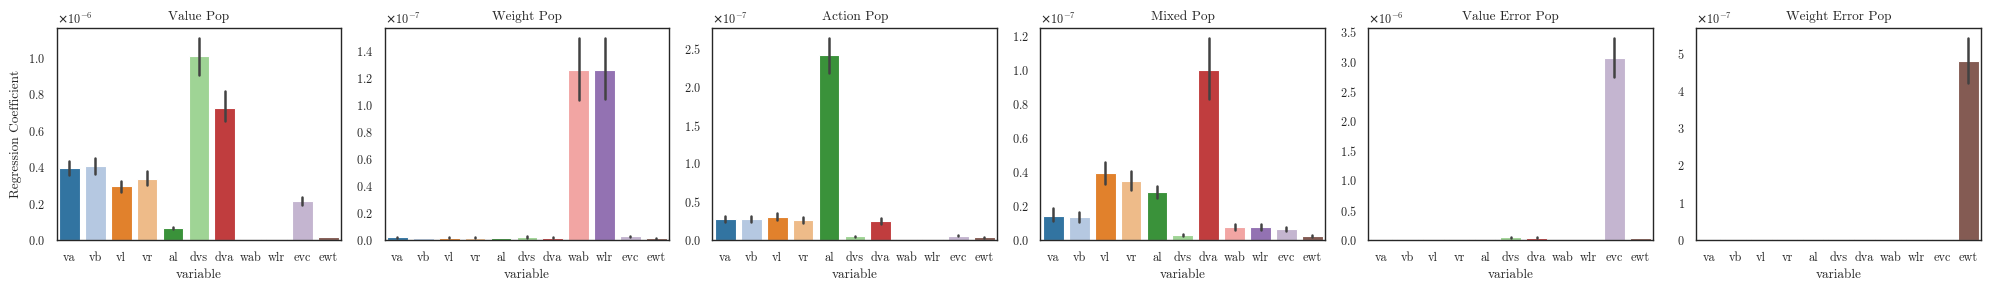

In [522]:
populations = nef_weights['population'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(20, 3), sharey=False)
for p, population in enumerate(populations):
    sns.barplot(nef_weights.query("population==@population"), x='variable', hue='variable', y='weight',
                ax=axes[p], palette=palette2[:len(variables)-1])
    axes[p].set(title=population)
axes[0].set(title="Value Pop", ylabel='Regression Coefficient')
axes[1].set(title="Weight Pop", ylabel=None)
axes[2].set(title="Action Pop", ylabel=None)
axes[3].set(title="Mixed Pop", ylabel=None)
axes[4].set(title="Value Error Pop", ylabel=None)
axes[5].set(title="Weight Error Pop", ylabel=None)
fig.tight_layout()
fig.savefig("plots/nef_regression_weights.jpg", dpi=600)

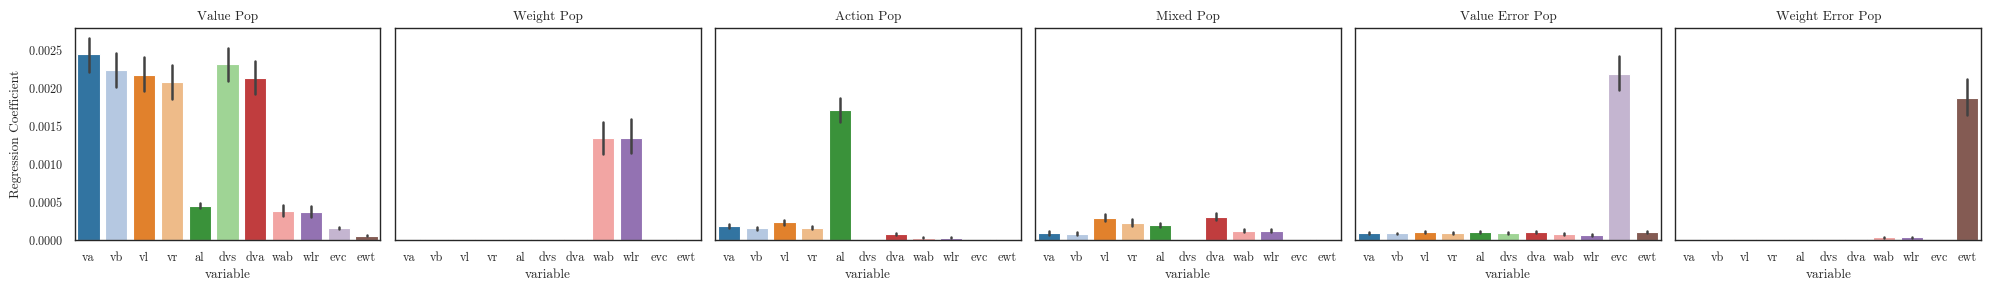

In [524]:
populations = nef_weights['population'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(20, 3), sharey=True)
for p, population in enumerate(populations):
    sns.barplot(nef_weights.query("population==@population"), x='variable', hue='variable', y='norm_weight',
                ax=axes[p], palette=palette2[:len(variables)-1])
    axes[p].set(title=population)
axes[0].set(title="Value Pop", ylabel='Regression Coefficient')
axes[1].set(title="Weight Pop", ylabel=None)
axes[2].set(title="Action Pop", ylabel=None)
axes[3].set(title="Mixed Pop", ylabel=None)
axes[4].set(title="Value Error Pop", ylabel=None)
axes[5].set(title="Weight Error Pop", ylabel=None)
fig.tight_layout()
fig.savefig("plots/nef_regression_norm_weights.jpg", dpi=600)

In [530]:
nef_weights.query("monkey=='V' and session==0 and neuron==1")

,monkey,session,neuron,population,variable,weight,norm_weight
1,V,0,1,v,va,1.752536e-05,0.116431
18001,V,0,1,v,vb,2.714229e-05,0.150902
36001,V,0,1,v,vl,1.273605e-06,0.014113
54001,V,0,1,v,vr,2.249764e-06,0.025864
72001,V,0,1,v,al,1.265822e-08,0.000099
90001,V,0,1,v,al,1.265822e-08,0.000099
108001,V,0,1,v,dvs,8.828775e-05,0.151437
126001,V,0,1,v,dva,6.908814e-06,0.033060
144001,V,0,1,v,wab,2.310037e-07,0.002909
162001,V,0,1,v,wlr,2.571588e-07,0.003240


### Figure 3.1
With the NEF model, we divide neurons into populations, and give each population a different set of variables to represent. Looking at the regression weights for each population, it is fairly easy to infer what those represented variables are. However, populations that represent value variables will also seem to represent total DV variables to some degree, and visa versa. Error populations have very distinct representations.

In [568]:
variables = ['V_StimL', 'V_StimR', 'V_Act1', 'V_Act2', 'DV_left', 'DV_right', 'DeltaV_Stim', 'DeltaV_Act', 'omega']
monkey_weights = regression_weights(monkey_spikes, rl_values, variables=variables, spike_type='monkey')
monkey_weights.to_pickle("data/monkey_regression_weights.pkl")

V 0
fitting model
V 1
fitting model
V 2
fitting model
V 3
fitting model
W 0
fitting model
W 1
fitting model
W 2
fitting model
W 3
fitting model


In [420]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), sharey=False)
# sns.barplot(monkey_weights, x='variable', hue='variable', y='weight', ax=axes, palette=palette)
# axes.set(title="All Neurons", ylabel='Regression Coefficient')
# fig.tight_layout()
# fig.savefig("plots/monkey_regression_weights.jpg", dpi=600)

/tmp/ipykernel_1314961/1638427300.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
/tmp/ipykernel_1314961/1638427300.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
/tmp/ipykernel_1314961/1638427300.py:5: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)


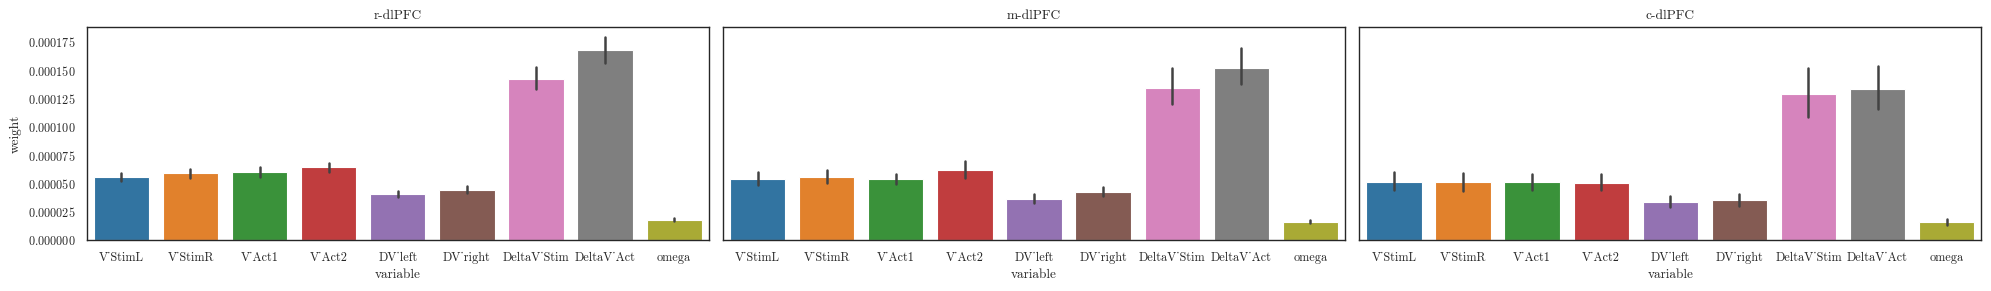

In [570]:
populations = monkey_weights['population'].unique()[:-1]
fig, axes = plt.subplots(nrows=1, ncols=len(populations), figsize=(20, 3), sharey=True)
# for p, population in enumerate(populations):
for p, population in enumerate(populations):
    sns.barplot(monkey_weights.query("population==@population"), x='variable', hue='variable', y='weight', ax=axes[p], palette=palette)
    axes[p].set(title=population)
# axes[0].set(title="Value Pop", ylabel='Regression Coefficient')
# axes[1].set(title="Weight Pop", ylabel=None)
# axes[2].set(title="Action Pop", ylabel=None)
# axes[3].set(title="Mixed Pop", ylabel=None)
fig.tight_layout()
fig.savefig("plots/monkey_regression_weights_bypop.jpg", dpi=600)

### Figure 3.2
The different labeled PFC regions don't seem to have systematic differences in whch variables they represent.

# 3. Cluster neurons by regression coefficients
For each plot, we look at all the neurons and pick a subset of variables (values, values+deltas, values+omega, decision variables, etc). Then we pick a number of target clusters and perform KMeans clustering to group the weights into that number of clusters. We also do PCA on the weights. Finally, we plot the top 2 PCs of the weight matrix, and colorize according to the clusters; we also look at the weight distribution in each color. We end up with a picture of how the weights for that subset of variables are clustered.

In [52]:
def cluster_and_plot(neuron_weights, n_clusters, normalize=None, exclude=[], plot3D=True):
    for var in exclude:
        neuron_weights = neuron_weights[neuron_weights['variable'] != var]
    pre_columns = ['monkey', 'session', 'neuron', 'population']
    tuning_df = neuron_weights.pivot_table(index=pre_columns, columns='variable', values='weight', aggfunc='first').dropna()
    tuning_matrix = tuning_df.to_numpy()

    if normalize=='neuron':
        norms = np.linalg.norm(tuning_matrix, axis=1)
        mask = norms > 1e-10  # or whatever threshold you're using
        tuning_matrix = tuning_matrix[mask]
        tuning_df = tuning_df.loc[mask].copy()  # ensure a view, not a slice
        norms_filtered = norms[mask][:, np.newaxis]
        tuning_matrix = tuning_matrix / norms_filtered

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans.fit_predict(tuning_matrix)
    tuning_df['cluster'] = cluster_labels

    abs_weights = np.abs(tuning_df.drop(columns='cluster'))
    dominant_var = abs_weights.idxmax(axis=1)
    tuning_df['dominant_variable'] = dominant_var

    # Fit PCA with enough components to compute explained variance for N PCs
    
    pca = PCA(n_components=3 if plot3D else 2)  
    proj = pca.fit_transform(tuning_matrix)
    explained_var = pca.explained_variance_ratio_

    # Compute cluster quality metrics
    sil_score = silhouette_score(tuning_matrix, cluster_labels)
    db_score = davies_bouldin_score(tuning_matrix, cluster_labels)
    ch_score = calinski_harabasz_score(tuning_matrix, cluster_labels)
    a = f"<br>Silhouette Score (higher = better separation and compactness):      {sil_score:.3f}"
    b = f"<br>Davies Bouldin Index (lower = tighter, well-separated clusters):    {db_score:.3f}"
    c = f"<br>Calinski Harabasz Score (higher = better defined clusters):         {ch_score:.1f}"
    d = f"<br>Percent variance explained by first {3 if plot3D else 2} PCs:       {100*explained_var.sum():.3f}%"
    e = 'Neuron Tuning Clusters (3D PCA Projection)'
    if plot3D:
        # colors = np.array([palette[i] for i in tuning_df['cluster']])
        # fig = plt.figure(figsize=(10, 8))
        # ax = fig.add_subplot(111, projection='3d')
        # scatter = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], color=colors, s=3, alpha=0.8)
        # ax.set_xlabel('PC1')
        # ax.set_ylabel('PC2')
        # ax.set_zlabel('PC3')
        df = pd.DataFrame({
            'PC1': proj[:, 0],
            'PC2': proj[:, 1],
            'PC3': proj[:, 2],
            'cluster': tuning_df['cluster'].astype(str)
        })
        hex_colors = [to_hex(c) for c in palette]
        fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='cluster',
                            color_discrete_sequence=hex_colors, opacity=1.0, title=e+a+b+c+d)
        fig.update_traces(marker=dict(size=2))
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=(8,5))
        sns.scatterplot(x=proj_2d[:, 0], y=proj_2d[:, 1], hue=tuning_df['cluster'], palette=palette[:n_clusters], ax=ax, s=5, edgecolor=None)
        ax.set(xlabel='PC1', ylabel='PC2', title='Neuron Tuning Clusters (PCA projection)'+a+b+c+d)
        ax.legend(title='Cluster')
        fig.tight_layout()
        # fig.savefig("plots/clustering.jpg", dpi=600)

    cluster_means = tuning_df.drop(columns=['cluster', 'dominant_variable']).groupby(tuning_df['cluster']).mean()
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(20,3), sharey=False)
    for i in range(n_clusters):
        sns.barplot(cluster_means.loc[i], color=palette[i], ax=axes[i])
        axes[i].tick_params(axis='x', labelrotation=45)
        axes[i].set(title=f"Cluster {i}", ylabel=None, yticks=[])
    axes[0].set(ylabel='Regression Weight')
    fig.tight_layout()

## NEF

In [77]:
# exclude = ['clet']
# for n_clusters in [3]:
#     cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

In [54]:
# exclude = ['dvs', 'dva', 'clet', 'rew']
# for n_clusters in [2,3,4,5,6]:
#     cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

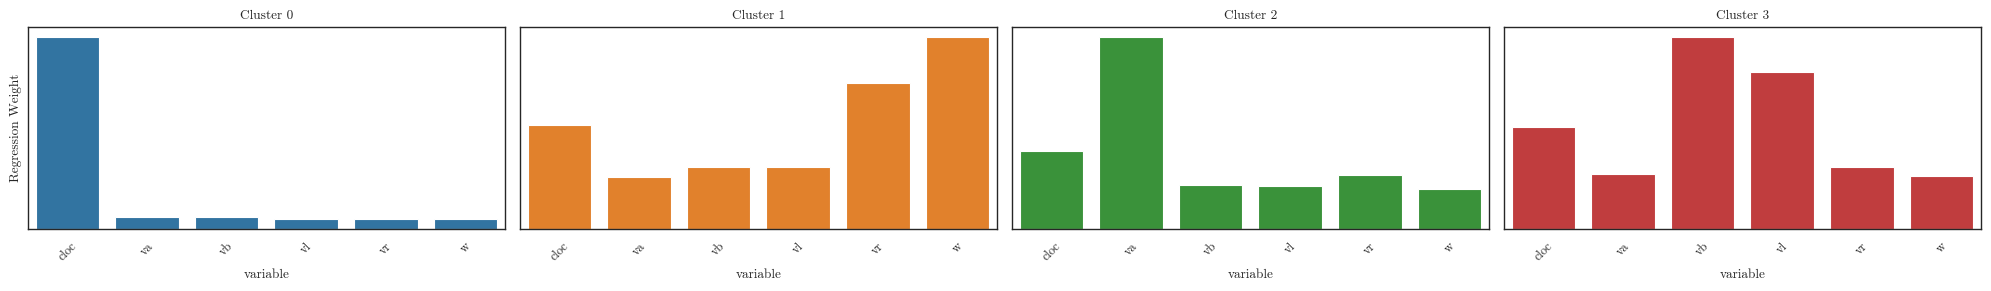

In [70]:
exclude = ['dvs', 'dva', 'al', 'ar', 'clet', 'rew']
for n_clusters in [4]:
    cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

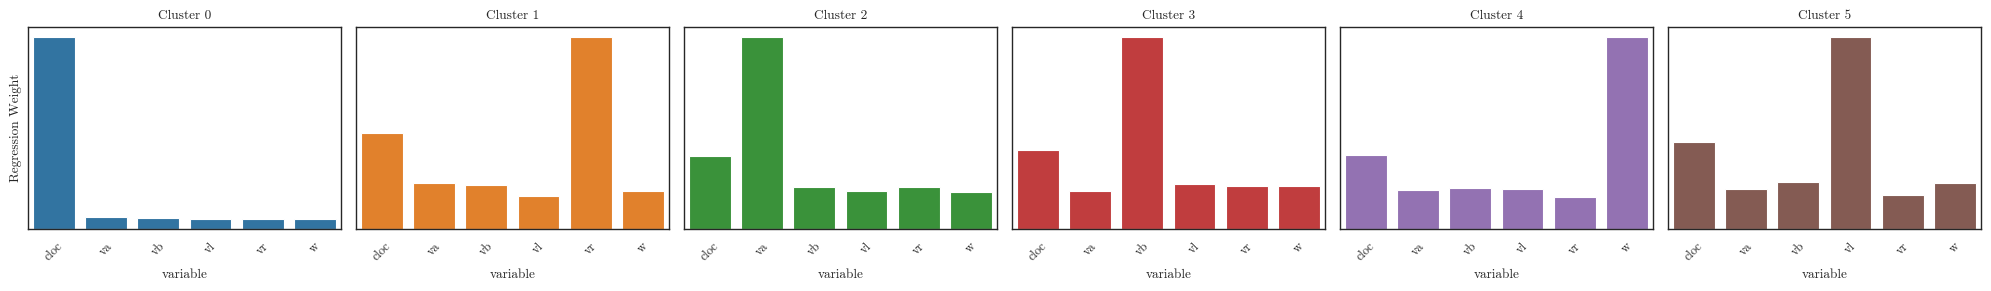

In [71]:
exclude = ['dvs', 'dva', 'al', 'ar', 'clet', 'rew']
for n_clusters in [6]:
    cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

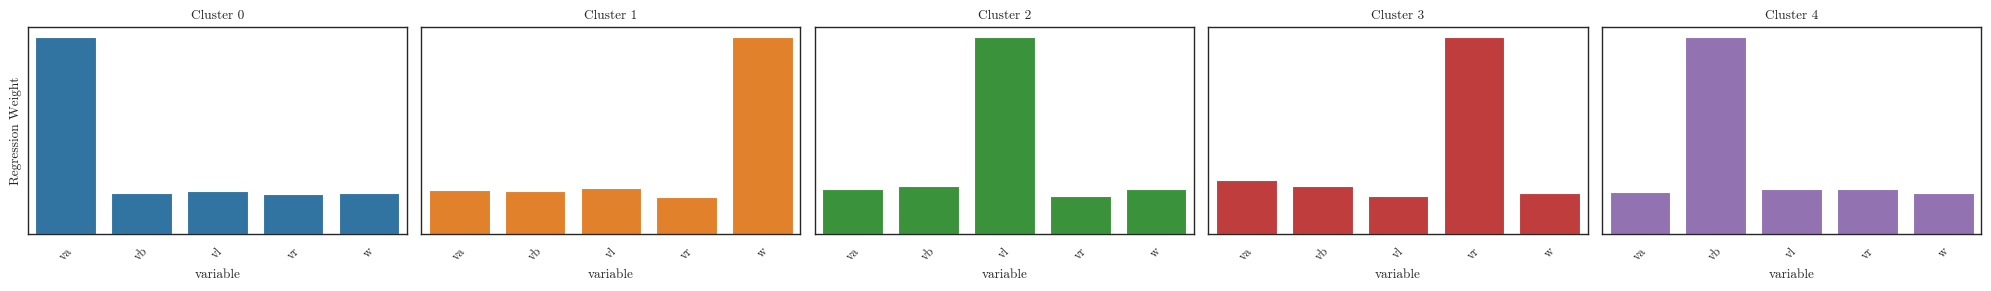

In [78]:
exclude = ['dvs', 'dva', 'al', 'ar', 'clet', 'rew', 'cloc']
for n_clusters in [5]:
    cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

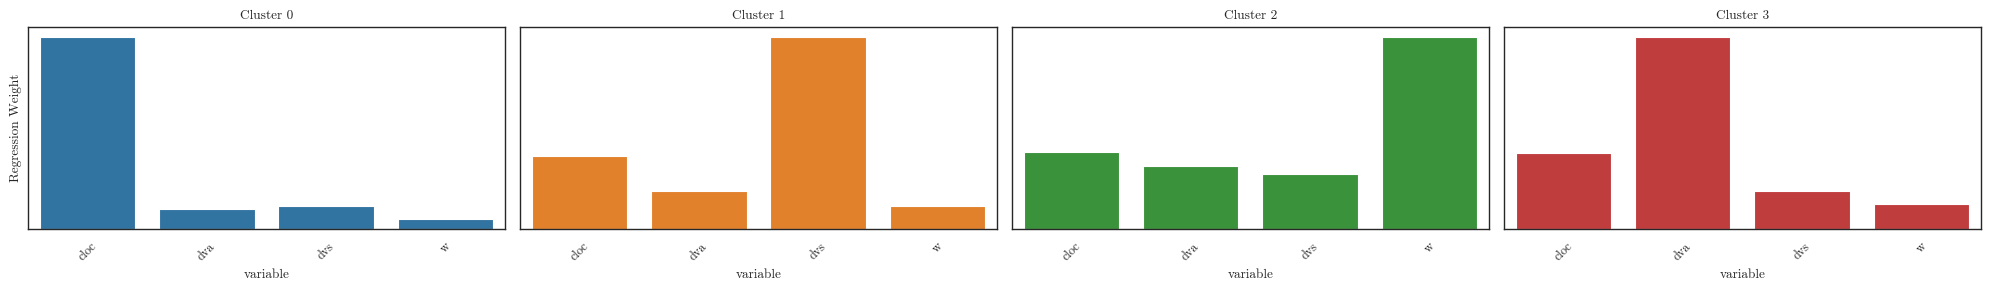

In [79]:
exclude = ['va', 'vb', 'vl', 'vr', 'al', 'ar', 'clet', 'rew']
for n_clusters in [4]:
    cluster_and_plot(cleaned_nef_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

## Monkey

In [35]:
# for n_clusters in [3,4,5]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron')

In [36]:
# exclude = ['reward', 'chosen location', 'DV_left', 'DV_right']
# for n_clusters in [3,6]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

In [37]:
# exclude = ['chosen location', 'reward', 'DeltaV_Stim', 'DeltaV_Act']
# for n_clusters in [4,5]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

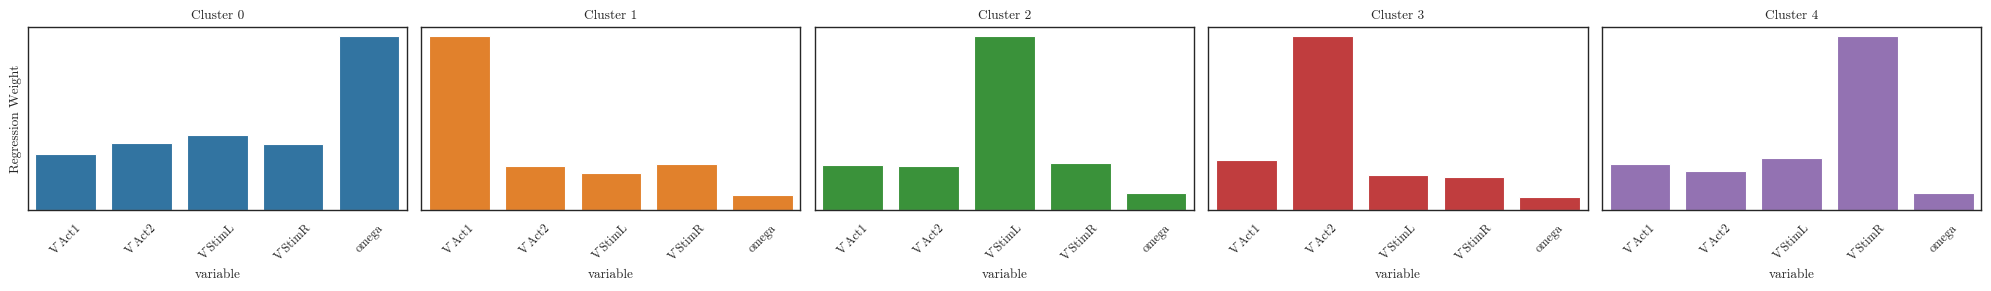

In [80]:
exclude = ['DeltaV_Stim', 'DeltaV_Act', 'DV_left', 'DV_right', 'chosen location', 'reward']
for n_clusters in [5]:
    cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

In [81]:
# exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR']
# for n_clusters in [4]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

In [82]:
# exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR', 'DV_left', 'DV_right']
# for n_clusters in [4]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

In [83]:
# exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR', 'chosen location', 'reward']
# for n_clusters in [3,4,5,6]:
#     cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

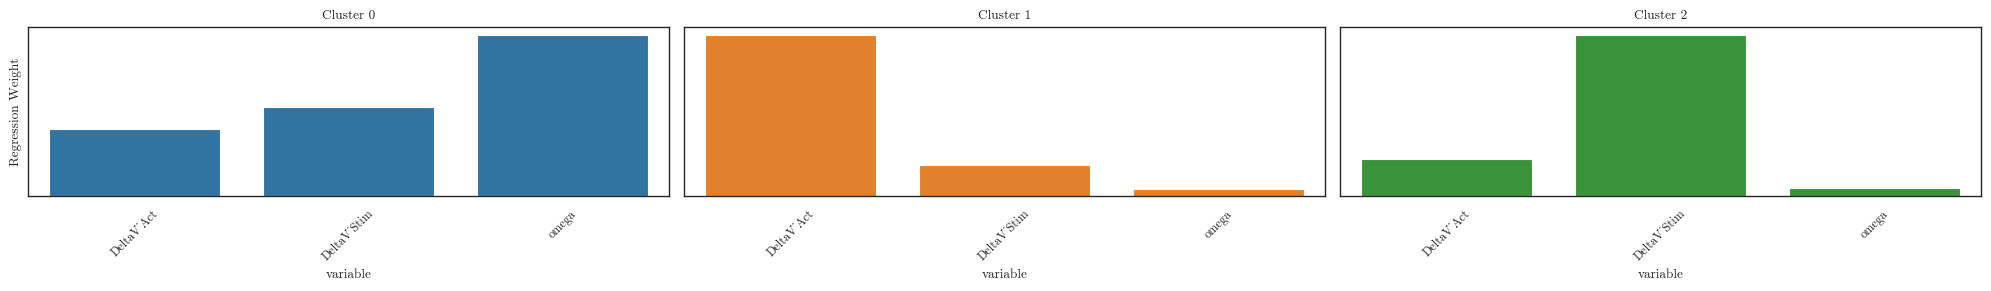

In [84]:
exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR', 'DV_left', 'DV_right', 'chosen location', 'reward']
for n_clusters in [3]:
    cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

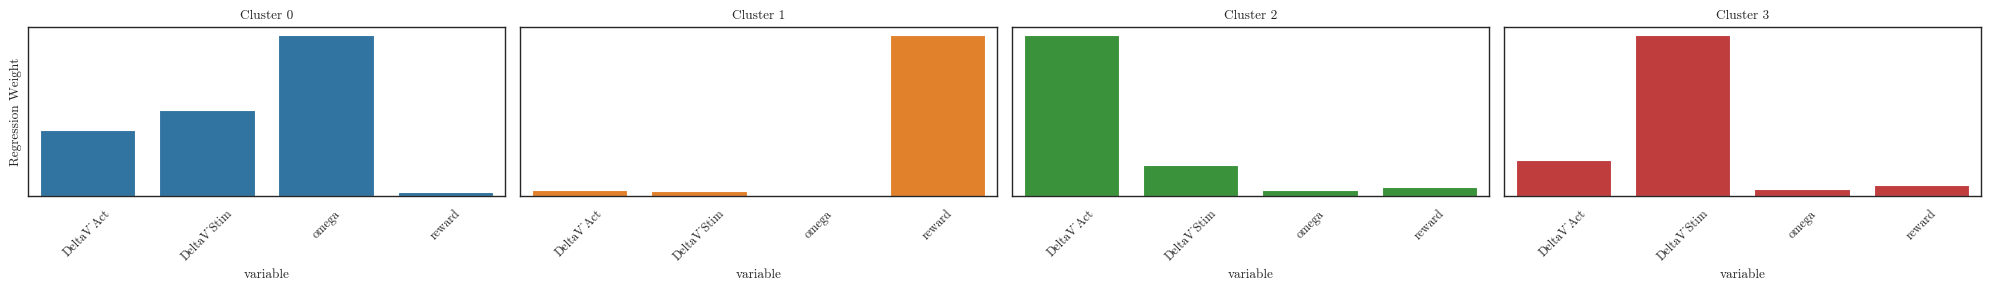

In [85]:
exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR', 'DV_left', 'DV_right', 'chosen location']
for n_clusters in [4]:
    cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)

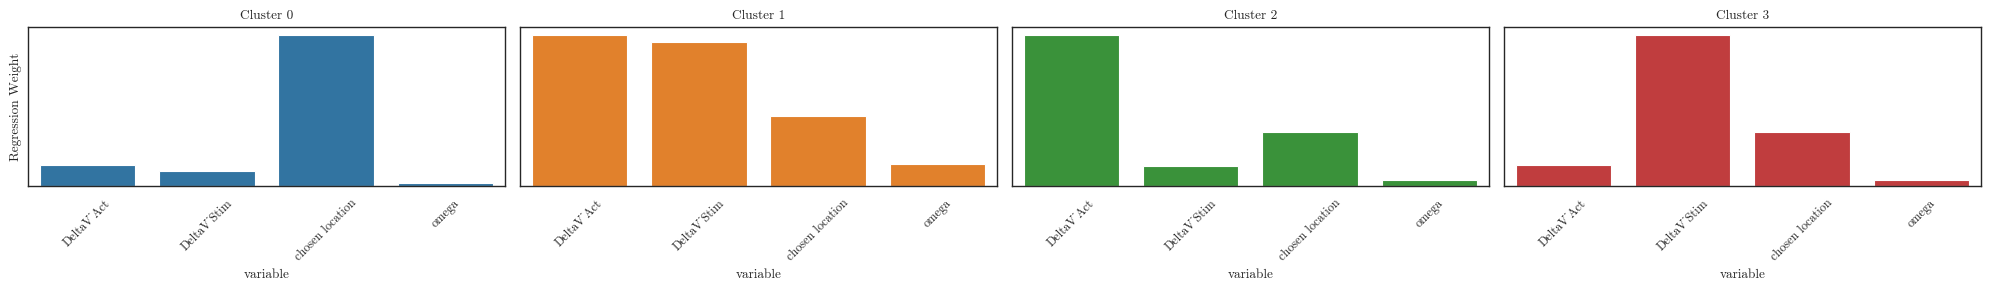

In [86]:
exclude = ['V_Act1', 'V_Act2', 'V_StimL', 'V_StimR', 'DV_left', 'DV_right', 'reward']
for n_clusters in [4]:
    cluster_and_plot(cleaned_monkey_weights, n_clusters=n_clusters, normalize='neuron', exclude=exclude)